# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

In [1]:
# Перед выполнением активируем GPU: Среда выполнения > Сменить среду выполнения > Аппаратный ускоритель: GPU

In [2]:
!pip install git+https://github.com/anjandeepsahni/torchutils.git

  Cloning https://github.com/anjandeepsahni/torchutils.git to /tmp/pip-req-build-9asx3ljq
  Running command git clone --filter=blob:none --quiet https://github.com/anjandeepsahni/torchutils.git /tmp/pip-req-build-9asx3ljq
  Resolved https://github.com/anjandeepsahni/torchutils.git to commit 6e2dcdb6a2b18b4e650fd738fecda779fe1822df
  Preparing metadata (setup.py) ... done
  Created wheel for torchutils: filename=torchutils-0.0.4-py3-none-any.whl size=20796 sha256=e44c80f66f60238a75219ad6d0c74c259741c9bdf82968b1ffd5904a50fde585
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_e_kumb/wheels/4a/94/e2/e3020b3c3324c75f181e73880c8a89a0646d818742dca2c679
Successfully built torchutils


In [3]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
print(torch.__version__, torchvision.__version__)

2.6.0+cu124 0.21.0+cu124


In [4]:
# скачиваем файл с словарем с расшифровкой классов ImageNet
if not os.path.exists('aux/imagenet_class_index.json'):
    os.makedirs('aux', exist_ok=True)
    !wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json -O aux/imagenet_class_index.json

--2025-09-11 07:18:08--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.17.86, 52.217.126.128, 54.231.129.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.17.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘aux/imagenet_class_index.json’

aux/imagenet_class_ 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2025-09-11 07:18:08 (562 KB/s) - ‘aux/imagenet_class_index.json’ saved [35363/35363]



Выход — это вектор из 1000 чисел, соответствующих вероятностям классов. Но сами индексы (от 0 до 999) — просто числа, а не названия.

- индекс класса (целое число от 0 до 999)

- ID класса в WordNet (например, "n01440764")

- человеческое название класса (например, "tench" — рыба «линь»)

```
{
  "0": ["n01440764", "tench"],
  "1": ["n01443537", "goldfish"],
  ...
  "999": ["n15075141", "toilet_tissue"]
}

```

## Transfer Learning

In [5]:
# делаем словарь, чтобы по индексу найти название класса
labels = json.load(open('aux/imagenet_class_index.json'))
# функция декодировки
decode = lambda x: labels[str(x)][1]

In [6]:
for key, value in list(labels.items())[:10]:
    print(f"{key}: {value}")

0: ['n01440764', 'tench']
1: ['n01443537', 'goldfish']
2: ['n01484850', 'great_white_shark']
3: ['n01491361', 'tiger_shark']
4: ['n01494475', 'hammerhead']
5: ['n01496331', 'electric_ray']
6: ['n01498041', 'stingray']
7: ['n01514668', 'cock']
8: ['n01514859', 'hen']
9: ['n01518878', 'ostrich']


In [7]:
decode(4)

'hammerhead'

MobileNetV3 Small — нейросеть, созданная для мобильных и встраиваемых устройств

In [8]:
# загружаем модель
# https://pytorch.org/vision/stable/models.html
model = torch.hub.load("pytorch/vision:v0.10.0", "mobilenet_v3_small", pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 108MB/s]


In [9]:
resize = T.Resize((224, 224)) #Меняет размер входного изображения на 224×224 пикселя

In [10]:
# скачаем картинку для теста
# !wget -O image.jpg https://petsi.net/images/dogbreed/big/10.jpg
if not os.path.exists('aux/image2.jpg'):
    !wget -O aux/image2.jpg https://www.supersadovnik.ru/binfiles/images/20220216/b275afb1.jpg

--2025-09-11 07:22:16--  https://www.supersadovnik.ru/binfiles/images/20220216/b275afb1.jpg
Resolving www.supersadovnik.ru (www.supersadovnik.ru)... 178.248.238.176
Connecting to www.supersadovnik.ru (www.supersadovnik.ru)|178.248.238.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44429 (43K) [image/jpeg]
Saving to: ‘aux/image2.jpg’

aux/image2.jpg      100%[===================>]  43.39K   227KB/s    in 0.2s    

2025-09-11 07:22:17 (227 KB/s) - ‘aux/image2.jpg’ saved [44429/44429]



In [11]:
img = resize(io.read_image('aux/image2.jpg')/255)

In [12]:
img

tensor([[[0.4444, 0.4496, 0.4510,  ..., 0.4196, 0.4175, 0.4157],
         [0.4444, 0.4496, 0.4510,  ..., 0.4196, 0.4175, 0.4157],
         [0.4444, 0.4496, 0.4510,  ..., 0.4196, 0.4175, 0.4157],
         ...,
         [0.3961, 0.3964, 0.3994,  ..., 0.3882, 0.3859, 0.3808],
         [0.3961, 0.3964, 0.3994,  ..., 0.3882, 0.3859, 0.3808],
         [0.3961, 0.3964, 0.3994,  ..., 0.3882, 0.3859, 0.3808]],

        [[0.4797, 0.4849, 0.4863,  ..., 0.4235, 0.4192, 0.4157],
         [0.4797, 0.4849, 0.4863,  ..., 0.4235, 0.4192, 0.4157],
         [0.4797, 0.4849, 0.4863,  ..., 0.4235, 0.4192, 0.4157],
         ...,
         [0.4824, 0.4827, 0.4857,  ..., 0.4510, 0.4487, 0.4436],
         [0.4824, 0.4827, 0.4857,  ..., 0.4510, 0.4487, 0.4436],
         [0.4824, 0.4827, 0.4857,  ..., 0.4510, 0.4487, 0.4436]],

        [[0.2719, 0.2771, 0.2784,  ..., 0.1647, 0.1690, 0.1725],
         [0.2719, 0.2771, 0.2784,  ..., 0.1647, 0.1690, 0.1725],
         [0.2719, 0.2771, 0.2784,  ..., 0.1647, 0.1690, 0.

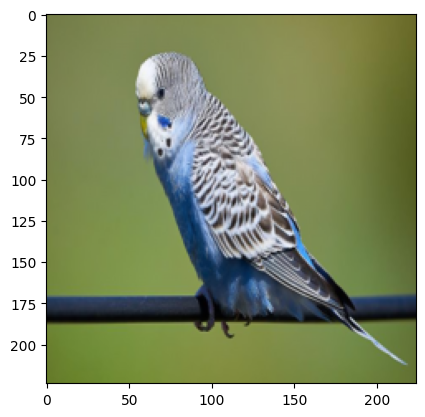

In [13]:
plt.imshow(torch.permute(img, (1, 2, 0))) #[channels, height, width]

In [14]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

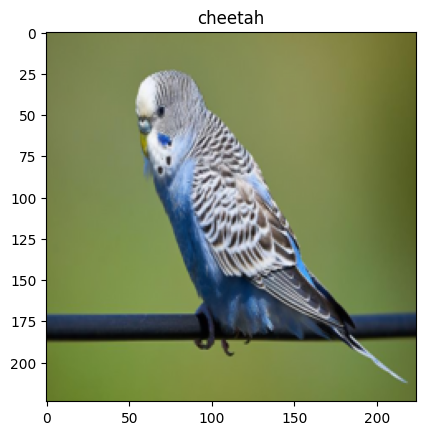

In [18]:
model.to(device)
model.eval()
plt.imshow(torch.permute(img, (1, 2, 0))) #Меняет порядок осей у тензора (C, H, W) → (H, W, C)
plt.title(decode(model(img.to(device).unsqueeze(0)).argmax().item())); #Добавляем размерность (1, C, H, W) и берем индекс максимального значения

In [19]:
decode(model(img.to(device).unsqueeze(0)).argmax().item())

'cheetah'

In [20]:
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

## Fine Tuning

In [22]:
import torchvision

In [23]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [24]:
model.classifier[3] #3й слой

Linear(in_features=1024, out_features=1000, bias=True)

In [26]:
model.classifier[3] = nn.Linear(1024, 1) # Заменяешь слой на 1024 признака и 1 выходное значение

In [25]:
if not os.path.exists('aux/catsdogs'):
    !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs_filtered.zip
    !unzip -qq cats_and_dogs_filtered.zip

--2025-09-11 07:37:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   281MB/s    in 0.2s    

2025-09-11 07:37:08 (281 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [27]:
trnsfrms = T.Compose([
    T.Resize((224, 224)), # Стандартизируем размер 224 × 224
    T.ToTensor() # Преобразуем в формат (C, H, W)
    ]
)

In [28]:
import torchvision
train_dataset = torchvision.datasets.ImageFolder('/content/cats_and_dogs_filtered/train',
                                                 transform=trnsfrms)
valid_dataset = torchvision.datasets.ImageFolder('/content/cats_and_dogs_filtered/validation',
                                                 transform=trnsfrms)

In [29]:
print(valid_dataset)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/cats_and_dogs_filtered/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [32]:
# замораживаем все веса в модели

# Проходим по всем параметрам модели (веса, смещения в слоях) и запрещаем вычисление градиентов т.е. во время обучения они не будут обновляться
for param in model.parameters():
    param.requires_grad = False

# Теперь включаем обучение только для последнего линейного слоя (classifier[3])
# Разрешаем обновлять его веса (матрица W)
model.classifier[3].weight.requires_grad = True
# Разрешаем обновлять его смещение (bias)
model.classifier[3].bias.requires_grad = True

model.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [33]:
#проверка, какие параметры модели сейчас обучаемые, а какие заморожены.
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
tu.get_model_summary(model, torch.randn(32, 3, 224, 224, device=device))

Layer                                                       Kernel              Output         Params          FLOPs
0_features.0.Conv2d_0                                     [3, 16, 3, 3]   [32, 16, 112, 112]       432   173,408,256
1_features.0.BatchNorm2d_1                                         [16]   [32, 16, 112, 112]        32    25,690,112
2_features.0.Hardswish_2                                              -   [32, 16, 112, 112]         0             0
3_features.1.block.0.Conv2d_0                             [1, 16, 3, 3]     [32, 16, 56, 56]       144    14,450,688
4_features.1.block.0.BatchNorm2d_1                                 [16]     [32, 16, 56, 56]        32     6,422,528
5_features.1.block.0.ReLU_2                                           -     [32, 16, 56, 56]         0             0
6_features.1.block.1.AdaptiveAvgPool2d_avgpool                        -       [32, 16, 1, 1]         0     1,606,144
7_features.1.block.1.Conv2d_fc1                           [16, 8

In [34]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

всего параметров у модели ~1.5M

обучаемые (trainable) только 1 025

остальные 1.5M «заморожены» (не обучаются, requires_grad=False).

In [36]:
# для одного батча
def compute_batch_accuracy(preds, labels):

    # preds имеет форму [batch_size, 1]
    # убираем лишнюю размерность (-1), получаем вектор [batch_size]
    preds_reshaped = preds.squeeze(-1)

    # применяем сигмоиду: переводим "логиты" в вероятности от 0 до 1
    preds_sigmoid = preds_reshaped.sigmoid()

    # округляем вероятности: <0.5 → 0, >=0.5 → 1
    # получаем предсказанные классы (0 или 1)
    preds_classes = torch.round(preds_sigmoid)

    # сравниваем предсказанные классы с реальными метками
    # получаем булев массив (True если совпало, False если нет)
    bool_array = preds_classes == labels

    # считаем количество правильных предсказаний
    number_of_true = bool_array.sum()

    # делим на количество примеров в батче → точность (accuracy)
    accuracy = number_of_true / len(labels)

    # переводим из тензора в обычное число float
    accuracy_float = accuracy.item()

    return accuracy_float

[Epoch 00] Train loss: 0.3946, valid loss = 0.3076 Train acc 0.8616 Valid acc 0.9395
[Epoch 01] Train loss: 0.2400, valid loss = 0.2604 Train acc 0.9221 Valid acc 0.9238
[Epoch 02] Train loss: 0.2058, valid loss = 0.1663 Train acc 0.9226 Valid acc 0.9180
[Epoch 03] Train loss: 0.1949, valid loss = 0.4032 Train acc 0.9177 Valid acc 0.9170
[Epoch 04] Train loss: 0.1818, valid loss = 0.0481 Train acc 0.9335 Valid acc 0.9248


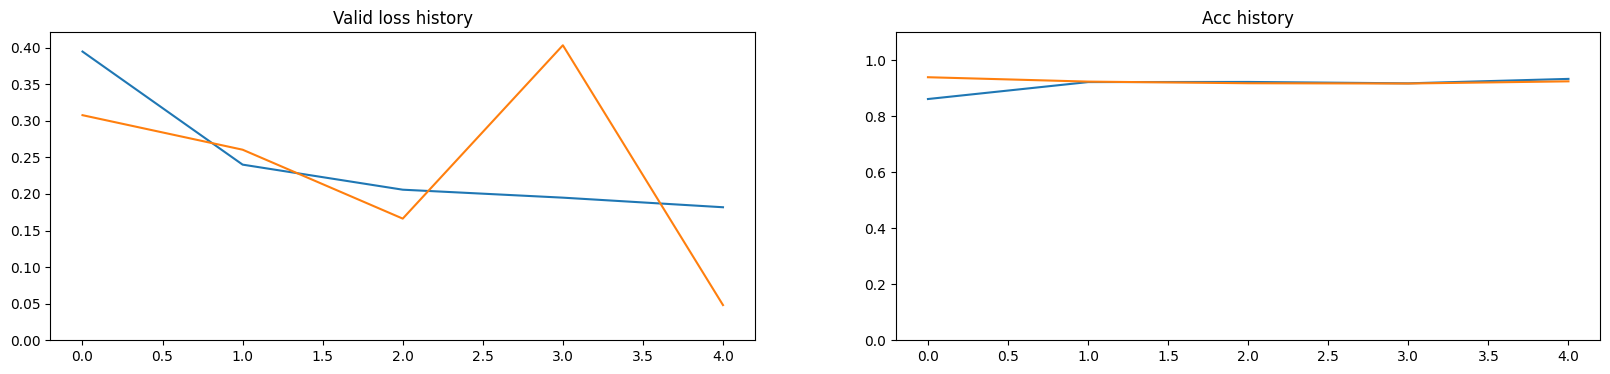

In [37]:
model.to(device)

train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(5):

    loss_batch = []
    acc_batch  = []

    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)

        loss = criterion(preds.squeeze(-1), labels.float())

        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)

        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))


    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))
    print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Valid loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');